# Spiking Graph JEPA (SG-JEPA) Evaluation


This notebook evaluates SG-JEPA, a self-supervised learning model for graphs.

**Key difference from supervised models:**
- GCN, GAT, GraphSAGE are **supervised** - they learn directly from labels
- SG-JEPA is **self-supervised** - it learns representations by predicting masked embeddings

**Evaluation Protocol:**
1. **Pre-training Loss**: How well does the model predict masked node embeddings?
2. **Linear Probing**: Freeze the encoder, train a linear classifier on learned representations
3. **Representation Quality**: Visualize embeddings, measure clustering quality


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans
from sg_jepa import SpikingGraphJEPA

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [19]:
# Install necessary packages
import subprocess
import sys

packages = ["torch-geometric", "scikit-learn", "matplotlib"]
for package in packages:
    try:
        __import__(package.replace("-", "_"))
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

## 1. Create Synthetic Dataset with Structure


We create a graph with community structure so learned representations should be meaningful.

In [20]:
def create_community_graph(num_nodes=500, num_communities=4, num_features=32, 
                           intra_prob=0.1, inter_prob=0.01):
    """
    Create a synthetic graph with community structure.
    Nodes in the same community are more likely to be connected.
    """
    # Assign nodes to communities
    nodes_per_community = num_nodes // num_communities
    labels = torch.tensor([i // nodes_per_community for i in range(num_nodes)])
    labels = torch.clamp(labels, max=num_communities - 1)
    
    # Create node features with community-based signal
    x = torch.randn(num_nodes, num_features)
    # Add community-specific bias to features
    for c in range(num_communities):
        mask = labels == c
        community_signal = torch.randn(num_features) * 0.5
        x[mask] += community_signal
    
    # Create edges based on community structure
    edges = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if labels[i] == labels[j]:
                if torch.rand(1).item() < intra_prob:
                    edges.append([i, j])
                    edges.append([j, i])
            else:
                if torch.rand(1).item() < inter_prob:
                    edges.append([i, j])
                    edges.append([j, i])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    return x, edge_index, labels, num_features, num_communities

# Create dataset
x, edge_index, labels, num_features, num_classes = create_community_graph(
    num_nodes=300, num_communities=4, num_features=32,
    intra_prob=0.08, inter_prob=0.005
)

print(f"Dataset Statistics:")
print(f"  Nodes: {x.shape[0]}")
print(f"  Features: {x.shape[1]}")
print(f"  Edges: {edge_index.shape[1]}")
print(f"  Communities: {num_classes}")
print(f"  Labels distribution: {torch.bincount(labels).tolist()}")

Dataset Statistics:
  Nodes: 300
  Features: 32
  Edges: 2118
  Communities: 4
  Labels distribution: [75, 75, 75, 75]


## 2. Self-Supervised Pre-training

Train SG-JEPA using the JEPA objective: predict target embeddings from context embeddings.

In [21]:
# Initialize model
hidden_dim = 64
embedding_dim = 128

model = SpikingGraphJEPA(
    num_features=num_features,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    mask_ratio=0.15
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Pre-training loop
num_epochs = 100
losses = []

print("Pre-training SG-JEPA...")
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass - model automatically masks nodes
    pred_embedding, target_embedding = model(x, edge_index)
    
    # JEPA Loss: MSE between predicted and target embeddings
    loss = F.mse_loss(pred_embedding, target_embedding)
    
    loss.backward()
    optimizer.step()
    
    # Update target encoder with EMA
    model.update_target_encoder(momentum=0.99)
    
    losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"  Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

print(f"\nFinal Pre-training Loss: {losses[-1]:.6f}")

Pre-training SG-JEPA...
  Epoch 20/100, Loss: 0.003995
  Epoch 40/100, Loss: 0.002158
  Epoch 60/100, Loss: 0.001634
  Epoch 80/100, Loss: 0.001333
  Epoch 100/100, Loss: 0.001316

Final Pre-training Loss: 0.001316


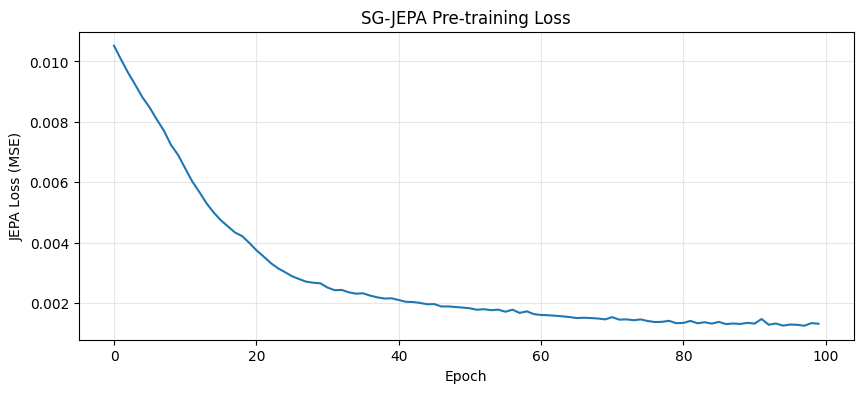

In [22]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('JEPA Loss (MSE)')
plt.title('SG-JEPA Pre-training Loss')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Linear Probing Evaluation

The standard way to evaluate self-supervised representations:
1. **Freeze** the pre-trained encoder
2. Train **only** a linear classifier on top
3. Compare with randomly initialized encoder and supervised baselines

In [23]:
from torch_geometric.nn import GCNConv

class LinearProbe(nn.Module):
    """Linear classifier on frozen representations"""
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Linear(input_dim, num_classes)
    
    def forward(self, embeddings):
        return self.classifier(embeddings)


class SupervisedGCN(nn.Module):
    """Standard supervised GCN for comparison"""
    def __init__(self, num_features, hidden_dim, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)


def train_linear_probe(embeddings, labels, train_mask, test_mask, epochs=100):
    """Train a linear probe on pre-computed embeddings"""
    probe = LinearProbe(embeddings.shape[1], labels.max().item() + 1)
    optimizer = torch.optim.Adam(probe.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        probe.train()
        optimizer.zero_grad()
        out = probe(embeddings)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()
    
    probe.eval()
    with torch.no_grad():
        out = probe(embeddings)
        pred = out[test_mask].argmax(dim=1)
        acc = accuracy_score(labels[test_mask].numpy(), pred.numpy())
    
    return acc


def train_supervised_gcn(x, edge_index, labels, train_mask, test_mask, 
                         hidden_dim=64, epochs=100):
    """Train supervised GCN end-to-end"""
    model = SupervisedGCN(x.shape[1], hidden_dim, labels.max().item() + 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(x, edge_index)
        loss = criterion(out[train_mask], labels[train_mask])
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        out = model(x, edge_index)
        pred = out[test_mask].argmax(dim=1)
        acc = accuracy_score(labels[test_mask].numpy(), pred.numpy())
    
    return acc

print("Evaluation functions defined.")

Evaluation functions defined.


In [24]:
# Create train/test split
num_nodes = x.shape[0]
perm = torch.randperm(num_nodes)
train_size = int(0.6 * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True
test_mask = ~train_mask

print(f"Train nodes: {train_mask.sum().item()}, Test nodes: {test_mask.sum().item()}")

# Extract embeddings from pre-trained SG-JEPA (frozen)
model.eval()
with torch.no_grad():
    sgjepa_embeddings = model.context_encoder(x, edge_index)

# Also get embeddings from a randomly initialized encoder (baseline)
random_model = SpikingGraphJEPA(num_features, hidden_dim, embedding_dim)
random_model.eval()
with torch.no_grad():
    random_embeddings = random_model.context_encoder(x, edge_index)

print(f"\nEmbedding shape: {sgjepa_embeddings.shape}")

Train nodes: 180, Test nodes: 120

Embedding shape: torch.Size([300, 128])


In [25]:
# Run multiple trials for robust comparison
num_trials = 5
results = {'SG-JEPA (Linear Probe)': [], 'Random Init (Linear Probe)': [], 
           'Supervised GCN': [], 'Raw Features (Linear Probe)': []}

print("Running evaluation (5 trials each)...\n")

for trial in range(num_trials):
    # Reshuffle train/test for each trial
    perm = torch.randperm(num_nodes)
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[perm[:train_size]] = True
    test_mask = ~train_mask
    
    # 1. SG-JEPA Linear Probe (our method)
    acc = train_linear_probe(sgjepa_embeddings.detach(), labels, train_mask, test_mask)
    results['SG-JEPA (Linear Probe)'].append(acc)
    
    # 2. Random encoder Linear Probe (baseline)
    acc = train_linear_probe(random_embeddings.detach(), labels, train_mask, test_mask)
    results['Random Init (Linear Probe)'].append(acc)
    
    # 3. Supervised GCN (upper bound reference)
    acc = train_supervised_gcn(x, edge_index, labels, train_mask, test_mask)
    results['Supervised GCN'].append(acc)
    
    # 4. Raw features Linear Probe (lower bound)
    acc = train_linear_probe(x, labels, train_mask, test_mask)
    results['Raw Features (Linear Probe)'].append(acc)

# Print results
print("=" * 55)
print("LINEAR PROBING RESULTS (Node Classification)")
print("=" * 55)
for method, accs in results.items():
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    print(f"{method:30} {mean_acc:.4f} +/- {std_acc:.4f}")
print("=" * 55)
print("\nNote: SG-JEPA should outperform Random Init and Raw Features.")
print("Supervised GCN is an upper bound (uses labels during training).")

Running evaluation (5 trials each)...

LINEAR PROBING RESULTS (Node Classification)
SG-JEPA (Linear Probe)         0.9933 +/- 0.0033
Random Init (Linear Probe)     0.9733 +/- 0.0033
Supervised GCN                 0.9883 +/- 0.0041
Raw Features (Linear Probe)    0.8150 +/- 0.0220

Note: SG-JEPA should outperform Random Init and Raw Features.
Supervised GCN is an upper bound (uses labels during training).


## 4. Representation Quality Analysis

Evaluate the quality of learned representations through:
- **t-SNE Visualization**: Do embeddings cluster by community?
- **Clustering Metrics**: NMI, Silhouette Score

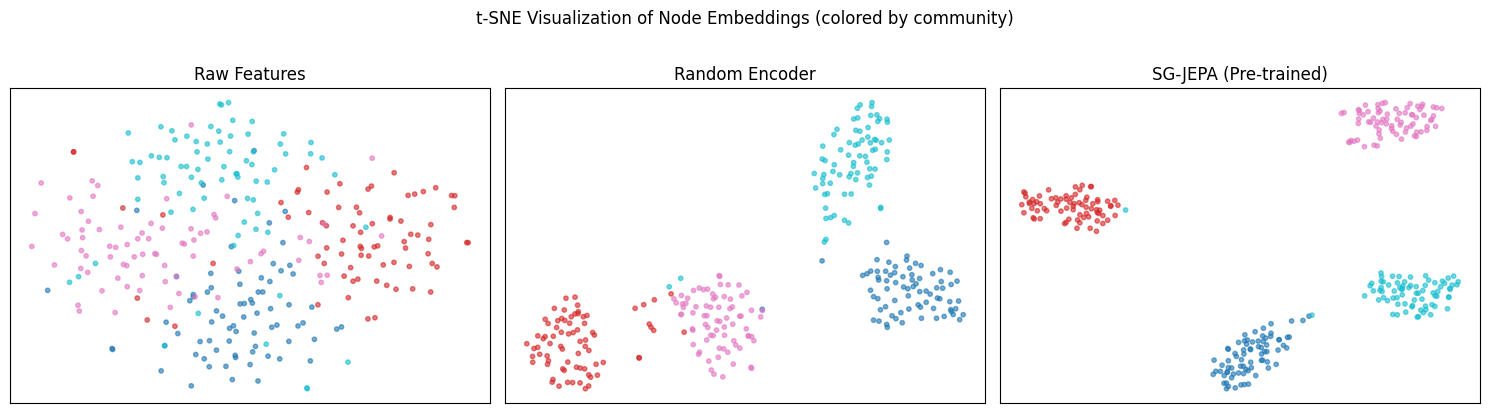

In [26]:
# t-SNE visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Raw features
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
raw_2d = tsne.fit_transform(x.numpy())
axes[0].scatter(raw_2d[:, 0], raw_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.6, s=10)
axes[0].set_title('Raw Features')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Random encoder
random_2d = tsne.fit_transform(random_embeddings.detach().numpy())
axes[1].scatter(random_2d[:, 0], random_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.6, s=10)
axes[1].set_title('Random Encoder')
axes[1].set_xticks([])
axes[1].set_yticks([])

# SG-JEPA
sgjepa_2d = tsne.fit_transform(sgjepa_embeddings.detach().numpy())
axes[2].scatter(sgjepa_2d[:, 0], sgjepa_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.6, s=10)
axes[2].set_title('SG-JEPA (Pre-trained)')
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.suptitle('t-SNE Visualization of Node Embeddings (colored by community)', y=1.02)
plt.tight_layout()
plt.show()

In [27]:
# Clustering metrics
def evaluate_clustering(embeddings, true_labels, name):
    """Evaluate clustering quality of embeddings"""
    n_clusters = true_labels.max().item() + 1
    
    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pred_labels = kmeans.fit_predict(embeddings.numpy())
    
    # Metrics
    nmi = normalized_mutual_info_score(true_labels.numpy(), pred_labels)
    silhouette = silhouette_score(embeddings.numpy(), true_labels.numpy())
    
    print(f"{name:25} NMI: {nmi:.4f}  Silhouette: {silhouette:.4f}")
    return nmi, silhouette

print("=" * 55)
print("CLUSTERING QUALITY METRICS")
print("=" * 55)
evaluate_clustering(x, labels, "Raw Features")
evaluate_clustering(random_embeddings.detach(), labels, "Random Encoder")
evaluate_clustering(sgjepa_embeddings.detach(), labels, "SG-JEPA (Pre-trained)")
print("=" * 55)
print("\nHigher NMI and Silhouette = better separation of communities.")

CLUSTERING QUALITY METRICS
Raw Features              NMI: 0.6286  Silhouette: 0.0561
Random Encoder            NMI: 0.8380  Silhouette: 0.2439
SG-JEPA (Pre-trained)     NMI: 0.9744  Silhouette: 0.4524

Higher NMI and Silhouette = better separation of communities.


## 5. Summary

This notebook evaluates SG-JEPA as a **self-supervised** graph representation learning method:

| Metric | What it measures |
|--------|------------------|
| Pre-training Loss | How well the model predicts masked embeddings |
| Linear Probe Accuracy | Quality of learned representations for classification |
| NMI Score | How well embeddings preserve community structure |
| Silhouette Score | How well-separated the embedding clusters are |

**Expected behavior:**
- SG-JEPA should learn meaningful representations without any labels
- Linear probing should outperform random initialization
- Embeddings should show better clustering than raw features